<a href="https://colab.research.google.com/github/zahidcsepstu/human_behavior_detection/blob/main/human_abnormal_behaviour_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

ROOT_DIR = '/content/drive/MyDrive/MS_THESIS'

VIDEO_DATA = ROOT_DIR + '/video_data'
IMAGE_DATA = ROOT_DIR + '/generated_data/image_data'
PREDICT_DATA = ROOT_DIR + '/generated_data/predict_data'
PROCESSED_DATA = ROOT_DIR + '/generated_data/processed_data'
TRAIN_DATA = PROCESSED_DATA + '/train'
TEST_DATA = PROCESSED_DATA + '/test'
DATASET_CSV = ROOT_DIR + '/dataset.csv'
MODEL_DIR = ROOT_DIR + '/generated_data/model_data/'

TEST_RATIO = 0.20

MODEL_PATH = ROOT_DIR + '/generated_data/human_behaviour_detection.h5'

In [ ]:
import pandas as pd

df = pd.read_csv(DATASET_CSV)
# print(df.to_string())

In [ ]:
def get_activity_class(frame, sequence):
    frame = int(frame)
    for x in range(len(df['sequence'])):
        if int(df['starting_frame'][x]) <= frame <= int(df['ending_frame'][x]) and str(df['sequence'][x]) == sequence:
            return df['activity_class'][x]
    return -1

In [ ]:
import cv2

def image_segmentation(sequence_name):
    videoCapture = cv2.VideoCapture(VIDEO_DATA + '/' + sequence_name + '.avi')

    success, image = videoCapture.read()
    count = 0
    while success:
        val = int(get_activity_class(count, sequence_name))
        if int(val) != -1:
            st = IMAGE_DATA + '/' + str(val) + '/' + sequence_name + "_frame_" + str(count) + ".jpg"
            # print(st)
            if not os.path.exists(IMAGE_DATA + '/' + str(val)):
                os.makedirs(IMAGE_DATA + '/' + str(val))
            cv2.imwrite(st, image)
        success, image = videoCapture.read()
        count += 1

image_segmentation('seq1')
# image_segmentation('seq2')

In [ ]:
import os
import numpy as np
import shutil
import random

classes_dir = ['/0', '/1', '/2', '/3', '/4', '/5']

for cls in classes_dir:
    if not os.path.exists(TRAIN_DATA + cls):
        os.makedirs(TRAIN_DATA + cls)
    if not os.path.exists(TEST_DATA + cls):
        os.makedirs(TEST_DATA + cls)



In [ ]:
def copy_image(folder_name):
    all_file_names = os.listdir(IMAGE_DATA + '/' + folder_name)

    np.random.shuffle(all_file_names)
    train_file_names, test_file_names = np.split(np.array(all_file_names), [int(len(all_file_names) * (1 - TEST_RATIO))])

    train_file_names = [IMAGE_DATA + '/' + folder_name + '/' + name for name in train_file_names.tolist()]
    test_file_names = [IMAGE_DATA + '/' + folder_name + '/' + name for name in test_file_names.tolist()]

    print("*****************************")
    print('Total images : ', len(all_file_names))
    print('Training     : ', len(train_file_names))
    print('Testing      : ', len(test_file_names))
    print("*****************************")

    for name in train_file_names:
        shutil.copy(name, TRAIN_DATA + '/' + folder_name)

    for name in test_file_names:
        shutil.copy(name, TEST_DATA + '/' + folder_name)

In [ ]:
for i in range(0, 6):
    copy_image(str(i))

*****************************
Total images :  154
Training     :  123
Testing      :  31
*****************************
*****************************
Total images :  144
Training     :  115
Testing      :  29
*****************************
*****************************
Total images :  90
Training     :  72
Testing      :  18
*****************************
*****************************
Total images :  98
Training     :  78
Testing      :  20
*****************************
*****************************
Total images :  80
Training     :  64
Testing      :  16
*****************************
*****************************
Total images :  83
Training     :  66
Testing      :  17
*****************************


In [ ]:
import keras
from keras.models import Model
from keras.layers import Dense
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

In [ ]:
train_data = ImageDataGenerator().flow_from_directory(directory=TRAIN_DATA, target_size=(224, 224))

test_data = ImageDataGenerator().flow_from_directory(directory=TEST_DATA, target_size=(224, 224))

Found 518 images belonging to 6 classes.
Found 131 images belonging to 6 classes.


In [ ]:
from keras.applications.vgg16 import VGG16

vgg_model = VGG16(weights='imagenet', include_top=True)
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
X = vgg_model.layers[-2].output
predictions = Dense(6, activation="softmax")(X)
model_final = Model(vgg_model.input, predictions)

In [ ]:
model_final.compile(loss="categorical_crossentropy", optimizer=optimizers.SGD(learning_rate=0.0001, momentum=0.9),metrics=["accuracy"])
model_final.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("human_behaviour_detection.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=40, verbose=1, mode='auto')
hist = model_final.fit(train_data, steps_per_epoch=2, epochs=40, validation_data=test_data,validation_steps=1, callbacks=[checkpoint, early])
model_final.save_weights(MODEL_PATH)
model_final.save(MODEL_DIR)

Epoch 1/40


1/2 [==============>...............] - ETA: 1:10 - loss: 2.4792 - accuracy: 0.1875

2/2 [==============================] - 168s 98s/step - loss: 2.1398 - accuracy: 0.1875 - val_loss: 1.9669 - val_accuracy: 0.3438
Epoch 2/40


1/2 [==============>...............] - ETA: 1:08 - loss: 1.9088 - accuracy: 0.2500

2/2 [==============================] - 154s 85s/step - loss: 1.8665 - accuracy: 0.2344 - val_loss: 1.4742 - val_accuracy: 0.5000
Epoch 3/40


1/2 [==============>...............] - ETA: 1:06 - loss: 1.7527 - accuracy: 0.4375

2/2 [==============================] - 173s 106s/step - loss: 1.7091 - accuracy: 0.3906 - val_loss: 1.1998 - val_accuracy: 0.5312
Epoch 4/40


1/2 [==============>...............] - ETA: 1:07 - loss: 1.2365 - accuracy: 0.5625

2/2 [==============================] - 173s 106s/step - loss: 1.3336 - accuracy: 0.5156 - val_loss: 1.2146 - val_accuracy: 0.5625
Epoch 5/40


1/2 [==============>...............] - ETA: 1:08 - loss: 1.2101 - accuracy: 0.5938

2/2 [==============================] - 154s 85s/step - loss: 1.1691 - accuracy: 0.5469 - val_loss: 0.9179 - val_accuracy: 0.7188
Epoch 6/40


1/2 [==============>...............] - ETA: 1:06 - loss: 0.8112 - accuracy: 0.8438

2/2 [==============================] - 152s 86s/step - loss: 0.7890 - accuracy: 0.8125 - val_loss: 0.8995 - val_accuracy: 0.7188
Epoch 7/40


1/2 [==============>...............] - ETA: 1:05 - loss: 0.9825 - accuracy: 0.5938

2/2 [==============================] - 151s 86s/step - loss: 0.8170 - accuracy: 0.6719 - val_loss: 0.8187 - val_accuracy: 0.6562
Epoch 8/40


1/2 [==============>...............] - ETA: 16s - loss: 0.8119 - accuracy: 0.5000

2/2 [==============================] - 104s 88s/step - loss: 0.8176 - accuracy: 0.7105 - val_loss: 0.9496 - val_accuracy: 0.7188
Epoch 9/40


1/2 [==============>...............] - ETA: 1:06 - loss: 0.9531 - accuracy: 0.6250

2/2 [==============================] - 153s 87s/step - loss: 0.8909 - accuracy: 0.6875 - val_loss: 0.5740 - val_accuracy: 0.9375
Epoch 10/40


1/2 [==============>...............] - ETA: 1:05 - loss: 0.5194 - accuracy: 0.8750

2/2 [==============================] - 153s 87s/step - loss: 0.6451 - accuracy: 0.8281 - val_loss: 0.7199 - val_accuracy: 0.7500
Epoch 11/40


1/2 [==============>...............] - ETA: 15s - loss: 0.5381 - accuracy: 0.8333

2/2 [==============================] - 98s 82s/step - loss: 0.5902 - accuracy: 0.8421 - val_loss: 0.5730 - val_accuracy: 0.8750
Epoch 12/40


1/2 [==============>...............] - ETA: 1:07 - loss: 0.7825 - accuracy: 0.7500

2/2 [==============================] - 159s 92s/step - loss: 0.5496 - accuracy: 0.8438 - val_loss: 0.4879 - val_accuracy: 0.7812
Epoch 13/40


1/2 [==============>...............] - ETA: 1:06 - loss: 0.4802 - accuracy: 0.8125

2/2 [==============================] - 152s 85s/step - loss: 0.4330 - accuracy: 0.8125 - val_loss: 0.6559 - val_accuracy: 0.8125
Epoch 14/40


1/2 [==============>...............] - ETA: 1:05 - loss: 0.5846 - accuracy: 0.8125

2/2 [==============================] - 155s 89s/step - loss: 0.4631 - accuracy: 0.8594 - val_loss: 0.3296 - val_accuracy: 0.8438
Epoch 15/40


1/2 [==============>...............] - ETA: 1:06 - loss: 0.2343 - accuracy: 0.9375

2/2 [==============================] - 157s 91s/step - loss: 0.2019 - accuracy: 0.9531 - val_loss: 0.2817 - val_accuracy: 0.9062
Epoch 16/40


1/2 [==============>...............] - ETA: 1:07 - loss: 0.2668 - accuracy: 0.9688

2/2 [==============================] - 155s 87s/step - loss: 0.2314 - accuracy: 0.9844 - val_loss: 0.3235 - val_accuracy: 0.9062
Epoch 17/40


1/2 [==============>...............] - ETA: 1:07 - loss: 0.2840 - accuracy: 0.9375

2/2 [==============================] - 153s 85s/step - loss: 0.2587 - accuracy: 0.9531 - val_loss: 0.2913 - val_accuracy: 0.9688
Epoch 18/40


1/2 [==============>...............] - ETA: 1:05 - loss: 0.2700 - accuracy: 0.9688

2/2 [==============================] - 152s 86s/step - loss: 0.2112 - accuracy: 0.9844 - val_loss: 0.0728 - val_accuracy: 1.0000
Epoch 19/40


1/2 [==============>...............] - ETA: 1:10 - loss: 0.1266 - accuracy: 0.9688

2/2 [==============================] - 153s 82s/step - loss: 0.1135 - accuracy: 0.9688 - val_loss: 0.1320 - val_accuracy: 0.9688
Epoch 20/40


1/2 [==============>...............] - ETA: 15s - loss: 0.3101 - accuracy: 0.8333

2/2 [==============================] - 103s 88s/step - loss: 0.1243 - accuracy: 0.9737 - val_loss: 0.1252 - val_accuracy: 0.9688
Epoch 21/40


1/2 [==============>...............] - ETA: 1:06 - loss: 0.1255 - accuracy: 0.9375

2/2 [==============================] - 153s 87s/step - loss: 0.1489 - accuracy: 0.9375 - val_loss: 0.1538 - val_accuracy: 0.9375
Epoch 22/40


1/2 [==============>...............] - ETA: 1:05 - loss: 0.0932 - accuracy: 0.9688

2/2 [==============================] - 152s 87s/step - loss: 0.0955 - accuracy: 0.9531 - val_loss: 0.1431 - val_accuracy: 0.9375
Epoch 23/40


1/2 [==============>...............] - ETA: 1:06 - loss: 0.0844 - accuracy: 1.0000

2/2 [==============================] - 152s 85s/step - loss: 0.0894 - accuracy: 0.9844 - val_loss: 0.1583 - val_accuracy: 0.9375
Epoch 24/40


1/2 [==============>...............] - ETA: 1:04 - loss: 0.0680 - accuracy: 0.9688

2/2 [==============================] - 99s 34s/step - loss: 0.0820 - accuracy: 0.9474 - val_loss: 0.0776 - val_accuracy: 1.0000
Epoch 25/40


1/2 [==============>...............] - ETA: 15s - loss: 0.1522 - accuracy: 1.0000

2/2 [==============================] - 103s 87s/step - loss: 0.0924 - accuracy: 1.0000 - val_loss: 0.1643 - val_accuracy: 0.9375
Epoch 26/40


1/2 [==============>...............] - ETA: 1:06 - loss: 0.1075 - accuracy: 0.9375

2/2 [==============================] - 151s 85s/step - loss: 0.2710 - accuracy: 0.8906 - val_loss: 0.1264 - val_accuracy: 0.9375
Epoch 27/40


1/2 [==============>...............] - ETA: 1:05 - loss: 0.0707 - accuracy: 1.0000

2/2 [==============================] - 152s 87s/step - loss: 0.0569 - accuracy: 1.0000 - val_loss: 0.3042 - val_accuracy: 0.8750
Epoch 28/40


1/2 [==============>...............] - ETA: 1:06 - loss: 0.1558 - accuracy: 0.9375

2/2 [==============================] - 152s 85s/step - loss: 0.1667 - accuracy: 0.9375 - val_loss: 0.0930 - val_accuracy: 0.9688
Epoch 29/40


1/2 [==============>...............] - ETA: 1:05 - loss: 0.2068 - accuracy: 0.9062

2/2 [==============================] - 151s 86s/step - loss: 0.1327 - accuracy: 0.9531 - val_loss: 0.0504 - val_accuracy: 1.0000
Epoch 30/40


1/2 [==============>...............] - ETA: 1:06 - loss: 0.0127 - accuracy: 1.0000

2/2 [==============================] - 151s 85s/step - loss: 0.0508 - accuracy: 0.9688 - val_loss: 0.0950 - val_accuracy: 0.9688
Epoch 31/40


1/2 [==============>...............] - ETA: 15s - loss: 0.1863 - accuracy: 1.0000

2/2 [==============================] - 98s 83s/step - loss: 0.1182 - accuracy: 0.9737 - val_loss: 0.2001 - val_accuracy: 0.8750
Epoch 32/40


1/2 [==============>...............] - ETA: 1:05 - loss: 0.0242 - accuracy: 1.0000

2/2 [==============================] - 151s 86s/step - loss: 0.0512 - accuracy: 0.9844 - val_loss: 0.4200 - val_accuracy: 0.9062
Epoch 33/40


1/2 [==============>...............] - ETA: 1:06 - loss: 0.3851 - accuracy: 0.9062

2/2 [==============================] - 157s 91s/step - loss: 0.2189 - accuracy: 0.9531 - val_loss: 0.1130 - val_accuracy: 0.9688
Epoch 34/40


1/2 [==============>...............] - ETA: 1:11 - loss: 0.3042 - accuracy: 0.9062

2/2 [==============================] - 163s 91s/step - loss: 0.1574 - accuracy: 0.9531 - val_loss: 0.0193 - val_accuracy: 1.0000
Epoch 35/40


1/2 [==============>...............] - ETA: 1:06 - loss: 0.0163 - accuracy: 1.0000

2/2 [==============================] - 151s 85s/step - loss: 0.0335 - accuracy: 0.9844 - val_loss: 0.0381 - val_accuracy: 1.0000
Epoch 36/40


1/2 [==============>...............] - ETA: 1:04 - loss: 0.0352 - accuracy: 1.0000

2/2 [==============================] - 151s 86s/step - loss: 0.0367 - accuracy: 1.0000 - val_loss: 0.0426 - val_accuracy: 1.0000
Epoch 37/40


1/2 [==============>...............] - ETA: 1:06 - loss: 0.0251 - accuracy: 1.0000

2/2 [==============================] - 151s 85s/step - loss: 0.0299 - accuracy: 1.0000 - val_loss: 0.0440 - val_accuracy: 1.0000
Epoch 38/40


1/2 [==============>...............] - ETA: 1:04 - loss: 0.0136 - accuracy: 1.0000

2/2 [==============================] - 151s 86s/step - loss: 0.0213 - accuracy: 1.0000 - val_loss: 0.0373 - val_accuracy: 1.0000
Epoch 39/40


1/2 [==============>...............] - ETA: 1:06 - loss: 0.0287 - accuracy: 1.0000

2/2 [==============================] - 151s 85s/step - loss: 0.0320 - accuracy: 1.0000 - val_loss: 0.0573 - val_accuracy: 0.9688
Epoch 40/40


1/2 [==============>...............] - ETA: 15s - loss: 0.1032 - accuracy: 1.0000

2/2 [==============================] - 100s 85s/step - loss: 0.0353 - accuracy: 1.0000 - val_loss: 0.0209 - val_accuracy: 1.0000


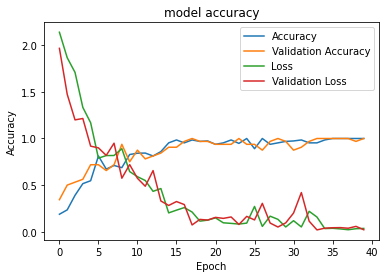

In [ ]:
import matplotlib.pyplot as pyplot

pyplot.plot(hist.history["accuracy"])
pyplot.plot(hist.history["val_accuracy"])
pyplot.plot(hist.history["loss"])
pyplot.plot(hist.history["val_loss"])

pyplot.title("model accuracy")
pyplot.xlabel("Epoch")
pyplot.ylabel("Accuracy")
pyplot.legend(["Accuracy", "Validation Accuracy", "Loss", "Validation Loss"])
pyplot.savefig(IMAGE_DATA + '/plot.jpg', dpi = 1000)

pyplot.show()

In [ ]:
from keras.models import load_model
model = load_model(MODEL_DIR)
model.load_weights(MODEL_PATH)

In [ ]:
import keras.utils as image
import numpy as np

def predict_image(path):
  imagePath = path
  test_image = image.load_img(imagePath, target_size= (224,224))
  test_image = image.img_to_array(test_image)
  test_image = np.expand_dims(test_image, axis = 0)
  result = model.predict(test_image, verbose = 0)
  predicted_class = np.argmax(result)
  return predicted_class

In [ ]:
predicted_class = predict_image('/content/drive/MyDrive/MS_THESIS/generated_data/processed_data/test/4/seq1_frame_772.jpg')
print('Predicted class : ', predicted_class)

Predicted class :  4


In [ ]:
import cv2

def image_segmentation_pred(sequence_name):
    videoCapture = cv2.VideoCapture(VIDEO_DATA + '/' + sequence_name + '.avi')

    success, image = videoCapture.read()
    count = 0
    while success:
        val = int(get_activity_class(count, sequence_name))
        if int(val) != -1:
            st = PREDICT_DATA + '/' + str(val) + '/' + sequence_name + "_frame_" + str(count) + ".jpg"
            # print(st)
            if not os.path.exists(PREDICT_DATA + '/' + str(val)):
                os.makedirs(PREDICT_DATA + '/' + str(val))
            cv2.imwrite(st, image)
        success, image = videoCapture.read()
        count += 1

# image_segmentation_pred('seq1')
image_segmentation_pred('seq3')
# image_segmentation_pred('seq4')
# image_segmentation_pred('seq5')
# image_segmentation_pred('seq6')

In [ ]:
import cv2

def image_segmentation_pred(sequence_name):
    videoCapture = cv2.VideoCapture(VIDEO_DATA + '/' + sequence_name + '.avi')

    success, image = videoCapture.read()
    count = 0
    a_0 =0
    a_1 =0
    a_2 =0
    a_3 =0
    a_4 =0
    a_5 =0

    while success:
        val = int(get_activity_class(count, sequence_name))
        if int(val) != -1:
            st = PREDICT_DATA + '/' + str(val) + '/' + sequence_name + "_frame_" + str(count) + ".jpg"
            
            if(int(val)==0):
              a_0+=1
              if(a_0<12):
                cv2.imwrite(st, image)
            if(int(val)==1):
              a_1+=1
              if(a_1<12):
                cv2.imwrite(st, image)
            if(int(val)==2):
              a_2+=1
              if(a_2<12):
                cv2.imwrite(st, image)
            if(int(val)==3):
              a_3+=1
              if(a_3<12):
                cv2.imwrite(st, image)
            if(int(val)==4):
              a_4+=1
              if(a_4<12):
                cv2.imwrite(st, image)
            if(int(val)==5):
              a_5+=1
              if(a_5<12):
                cv2.imwrite(st, image)
        success, image = videoCapture.read()
        count += 1

# image_segmentation_pred('seq1')
image_segmentation_pred('seq3')
# image_segmentation_pred('seq4')
# image_segmentation_pred('seq5')
# image_segmentation_pred('seq6')

In [ ]:
import os

def predict_all_class(activity_class):
  directory = PREDICT_DATA + '/' + str(activity_class)
  num_of_files = 0
  correct_prediction = 0
  for filename in os.listdir(directory):
      f = os.path.join(directory, filename)
      if os.path.isfile(f):
        num_of_files += 1
        # print(f)
        r = predict_image(f)
        # print(r)
        if(r == activity_class):
          correct_prediction +=1
          
  print("*****************************")
  print('Activity Class     : ', str(activity_class))
  print('Total Files        : ', num_of_files)
  print('Correct Prediction : ', correct_prediction)
  print('Accuracy           : ', str(round(correct_prediction/num_of_files*100,2)) + ' %')
  print("*****************************")        

In [ ]:
for i in range(0, 6):
    predict_all_class(i)


*****************************
Activity Class     :  0
Total Files        :  165
Correct Prediction :  153
Accuracy           :  92.73 %
*****************************
*****************************
Activity Class     :  1
Total Files        :  155
Correct Prediction :  149
Accuracy           :  96.13 %
*****************************
*****************************
Activity Class     :  2
Total Files        :  101
Correct Prediction :  90
Accuracy           :  89.11 %
*****************************
*****************************
Activity Class     :  3
Total Files        :  109
Correct Prediction :  98
Accuracy           :  89.91 %
*****************************
*****************************
Activity Class     :  4
Total Files        :  91
Correct Prediction :  80
Accuracy           :  87.91 %
*****************************
*****************************
Activity Class     :  5
Total Files        :  94
Correct Prediction :  83
Accuracy           :  88.3 %
*****************************
